<a href="https://colab.research.google.com/github/MelissaMatindi/FraudWatch-Project/blob/main/FraudWatch_Project_da_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📌 **FraudWatch Africa — Unsupervised Mobile Money Fraud Detection**


📌 **Project Overview**

Mobile money platforms have transformed financial access in Sub-Saharan Africa, enabling millions to send, receive, and manage funds via mobile devices. Unfortunately, this rapid adoption has also fueled a rise in fraud — from SIM swaps to unauthorized high-value transactions — threatening user trust and platform integrity.

**FraudWatch Africa project** aims to tackle this challenge using unsupervised machine learning to detect anomalous transactions without relying on labeled fraud data, a common limitation in emerging markets due to privacy laws and scarce fraud records.

The solution focuses on:

🔹Pattern analysis of transaction behaviors (amounts, timing, frequency, device type, location).

🔹Isolation Forest and other anomaly detection techniques to flag suspicious activity.

🔹Interactive visual monitoring via a Streamlit dashboard.

🔹Real-time deployment potential using FastAPI for integration with mobile money systems.

🎯 **Key Objectives**

🔹Build a scalable anomaly detection pipeline tailored for mobile money transactions.

🔹Identify irregular activity such as unusual transaction times, amounts, or location shifts.

🔹Provide actionable insights to analysts through interactive visualizations.

🔹Enable real-time fraud monitoring in production environments.


📂 **Dataset**

🔹The working dataset simulates real-world mobile money transactions, capturing:

🔹Transaction details (ID, type, amount, timestamp, channel).

🔹User and device information (ID, location, verification status, device type, demographics).

🔹Generated anomaly scores and fraud indicators for evaluation.

🛠️ **Technology Stack**

🔹**Data Processing & Modeling:** Python, Pandas, NumPy, Scikit-learn

🔹**Visualization:** Plotly, Matplotlib

🔹**Deployment & Monitoring:** Streamlit, FastAPI

📂 **DATA IMPORT & INITIAL EXPLORATION**

In [2]:
#import dependencies
import pandas as pd
import numpy as np

🔹Imported essential dependencies for data manipulation and numerical computation:

**pandas** 🐼 — For handling tabular data, reading files, and performing DataFrame operations.

**numpy** 🔢 — For efficient numerical computations and array manipulations.

In [3]:

# Since we are using Google colab
from google.colab import files
uploaded=files.upload()

Saving kenya_fraud_detection.xlsx to kenya_fraud_detection.xlsx


📥 **Loading the Dataset**

In [4]:
fraud_data = pd.read_excel('kenya_fraud_detection.xlsx')
fraud_data.head()

,Unnamed: 0,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,"time_of_day(morning, afternoon, evening, night)",is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime
0,0,TX100000,user_8270,Withdraw Cash,2646.35,Nakuru,Feature Phone,Telkom Kenya,individual,NaN,0,0,0,2024-06-16 21:45:13
1,1,TX100001,user_1860,Send Money,2844.69,Garissa,iOS,Safaricom,agent,NaN,0,0,0,2024-06-05 00:49:25
2,2,TX100002,user_6390,Deposit Cash,2384.46,Nyeri,Feature Phone,Telkom Kenya,agent,NaN,0,0,1,2024-06-13 15:54:02
3,3,TX100003,user_6191,Withdraw Cash,1846.01,Nairobi,iOS,Safaricom,individual,NaN,0,0,1,2024-06-10 01:05:49
4,4,TX100004,user_6734,Send Money,1017.60,Machakos,Feature Phone,Telkom Kenya,individual,NaN,0,0,0,2024-06-27 02:28:53


🔹Loaded the dataset into a DataFrame named fraud_data.

🔹Displayed the first 5 rows to get a quick look at the structure and values.

🧐 **Insight:**
We can already see **key** columns like transaction_id, user_id, transaction_type, amount, location, and fraud-related flags (is_foreign_number, is_sim_recently_swapped, has_multiple_accounts). However, one column — time_of_day(morning, afternoon, evening, night) — appears to have only **NaN** values. This is a potential data quality issue to address in the cleaning phase.

📏 **CHECKING DATASET DIMENSIONS**

In [5]:
# check shape of data
fraud_data.shape

(10000, 14)

In [6]:
# check dataset information
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Unnamed: 0                                       10000 non-null  int64         
 1   transaction_id                                   10000 non-null  object        
 2   user_id                                          10000 non-null  object        
 3   transaction_type                                 10000 non-null  object        
 4   amount                                           10000 non-null  float64       
 5   location                                         10000 non-null  object        
 6   device_type                                      10000 non-null  object        
 7   network_provider                                 10000 non-null  object        
 8   user_type                            

💵 **Summary Statistics for Transaction Amounts**

In [7]:
# amount is the only numerical column, so we check the summary statistics
fraud_data["amount"].describe()

,amount
count,10000.000000
mean,3496.408626
std,3507.288508
min,0.030000
25%,994.900000
50%,2389.835000
75%,4847.737500
max,30221.300000


**Observation:** Highly skewed distribution — most transactions are in the lower range, but some very high-value outliers exist.

💡 **Fraud Insight:**
Fraudulent transactions often occur at extreme values (very high or very low amounts) compared to typical behavior. This statistic will guide feature scaling and model sensitivity during anomaly detection.

🧹 **DATA CLEANING**

This Section focuses on ensuring dataset **integrity**, removing inconsistencies, and **preparing** the data for preprocessing and modeling.

In [8]:
#Removing artifact columns
print(fraud_data["Unnamed: 0"].head())
fraud_data = fraud_data.drop(columns=["Unnamed: 0"], errors="ignore")

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64



🗑 **Removing Artifact Columns**

**Why?** The Unnamed: 0 column is likely an index artifact from previous exports (e.g. Excel or CSV save). It carries no predictive value.

🔍 **Duplicate Checks**

In [9]:
# Checking for Duplicates

print("\nDuplicate rows:", fraud_data.duplicated().sum())
print("Duplicate transaction_ids:", fraud_data["transaction_id"].duplicated().sum())
fraud_data = fraud_data.drop_duplicates()
print("Dataset shape after removing duplicates:", fraud_data.shape)


Duplicate rows: 0
Duplicate transaction_ids: 0
Dataset shape after removing duplicates: (10000, 13)


**Result:** No duplicates found — ✅ dataset is unique for each transaction.

🩺 **Missing & Invalid Value Inspection**

In [10]:
#Checking for Missing or Invalid Values
print("\nMissing values:")
fraud_data.isnull().sum()


Missing values:


,0
transaction_id,0
user_id,0
transaction_type,0
amount,0
location,0
device_type,0
network_provider,0
user_type,0
"time_of_day(morning, afternoon, evening, night)",10000
is_foreign_number,0


In [11]:
print("\nEmpty strings:")
fraud_data.eq("").sum()


Empty strings:


,0
transaction_id,0
user_id,0
transaction_type,0
amount,0
location,0
device_type,0
network_provider,0
user_type,0
"time_of_day(morning, afternoon, evening, night)",0
is_foreign_number,0


In [12]:
print("\nInvalid entries (N/A, NA, None):")
fraud_data.isin(["N/A", "NA", "None"]).sum()


Invalid entries (N/A, NA, None):


,0
transaction_id,0
user_id,0
transaction_type,0
amount,0
location,0
device_type,0
network_provider,0
user_type,0
"time_of_day(morning, afternoon, evening, night)",0
is_foreign_number,0


**Findings:**

🔹The time_of_day(morning, afternoon, evening, night) column is **100% null**.

🔹No empty strings or invalid placeholders found.

💡 **Insight:** Instead of dropping the time_of_day column, we can derive it from the datetime column — ensuring we preserve useful temporal information.

📊 **Unique Value Analysis**

In [13]:
# print total unique values in each column
total_cols = fraud_data.columns.to_list()
for i in total_cols:
    print(f"{i}: {fraud_data[i].nunique()} unique values")

transaction_id: 10000 unique values
user_id: 6002 unique values
transaction_type: 14 unique values
amount: 9922 unique values
location: 10 unique values
device_type: 3 unique values
network_provider: 3 unique values
user_type: 2 unique values
time_of_day(morning, afternoon, evening, night): 0 unique values
is_foreign_number: 2 unique values
is_sim_recently_swapped: 2 unique values
has_multiple_accounts: 2 unique values
datetime: 9979 unique values


In [14]:
# categorical columns
# create an empty list
cat_cols = []

for i in total_cols:
  # define categorical columns as those with less than 20 unique values
    if fraud_data[i].nunique() < 20:
        cat_cols.append(i)

cat_cols

['transaction_type',
 'location',
 'device_type',
 'network_provider',
 'user_type',
 'time_of_day(morning, afternoon, evening, night)',
 'is_foreign_number',
 'is_sim_recently_swapped',
 'has_multiple_accounts']

In [15]:
# print the unique values in the categorical columns
for i in cat_cols:
    print(f"{i}: {fraud_data[i].unique()}")

transaction_type: ['Withdraw Cash' 'Send Money' 'Deposit Cash' '  Send   Money'
 'Lipa na    M-Pesa' 'Buy Airtime' 'Lipa na M-Pesa' 'Pay Bill'
 'Pay    Bill' '  Buy    Airtime' '   Withdraw   Cash' ' Buy   Airtime  '
 'Lipa   na M-Pesa' 'Send   Money']
location: ['Nakuru' 'Garissa' 'Nyeri' 'Nairobi' 'Machakos' 'Meru' 'Kisumu' 'Mombasa'
 'Eldoret' 'Thika']
device_type: ['Feature Phone' 'iOS' 'Android']
network_provider: ['Telkom Kenya' 'Safaricom' 'Airtel']
user_type: ['individual' 'agent']
time_of_day(morning, afternoon, evening, night): [nan]
is_foreign_number: [0 1]
is_sim_recently_swapped: [0 1]
has_multiple_accounts: [0 1]


🧽 **Fixing Categorical Inconsistencies**

In [16]:
# remove all inconsistencies in transaction_type
print(f"transaction_type before cleaning:\n{fraud_data['transaction_type'].unique()}\n")

# remove leading and trailng spaces
fraud_data["transaction_type"] = fraud_data["transaction_type"].str.strip()
# replace multiplr internal spaces with just a single space
fraud_data["transaction_type"] = fraud_data["transaction_type"].str.replace(r'\s+', ' ', regex=True)

print(f"transaction_type after cleaning:\n{fraud_data['transaction_type'].unique()}")

transaction_type before cleaning:
['Withdraw Cash' 'Send Money' 'Deposit Cash' '  Send   Money'
 'Lipa na    M-Pesa' 'Buy Airtime' 'Lipa na M-Pesa' 'Pay Bill'
 'Pay    Bill' '  Buy    Airtime' '   Withdraw   Cash' ' Buy   Airtime  '
 'Lipa   na M-Pesa' 'Send   Money']

transaction_type after cleaning:
['Withdraw Cash' 'Send Money' 'Deposit Cash' 'Lipa na M-Pesa'
 'Buy Airtime' 'Pay Bill']


🔹Removed leading/trailing spaces and extra spaces within strings in transaction_type.

Example: " Send Money" → "Send Money".

**Benefit:** Prevents model treating "Send Money" and " Send Money" as different categories.

✅**Validating Binary Columns**

In [17]:
#Validating Binary Columns
binary_cols = ["is_foreign_number", "is_sim_recently_swapped", "has_multiple_accounts"]
for col in binary_cols:
    invalid = ~fraud_data[col].isin([0, 1])
    if invalid.any():
        print(f"\nInvalid values in {col}:", fraud_data[col][invalid].unique())
        fraud_data[col] = fraud_data[col].clip(0, 1)
    fraud_data[col] = fraud_data[col].astype("category")
print("\nBinary columns validated:", binary_cols)


Binary columns validated: ['is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts']


🔹Ensured binary features only contain 0 or 1.

🔹Converted them to categorical dtype for memory efficiency and clarity.

🏷 **Converting Categorical Columns**

In [18]:
# Converting Categorical Columns
cat_cols = ["transaction_type", "location", "device_type", "network_provider", "user_type", "time_of_day",
            "is_foreign_number", "is_sim_recently_swapped", "has_multiple_accounts"]
for col in cat_cols:
    if col in fraud_data.columns:
        fraud_data[col] = fraud_data[col].str.title() if fraud_data[col].dtype == "object" else fraud_data[col]
        fraud_data[col] = fraud_data[col].astype("category")
print("\nCategorical columns converted:", cat_cols)


Categorical columns converted: ['transaction_type', 'location', 'device_type', 'network_provider', 'user_type', 'time_of_day', 'is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts']


🔹Converted low-cardinality columns into **pandas** categorical types.

**Benefits:** Reduced memory usage from 1.1 MB → 470 KB 📉 and improved performance in model encoding.

⏰ **Deriving time_of_day from datetime**

In [19]:
# get the time of the day
def get_time_of_day(hour):
  """
    This function takes in the hour of the day, in which the transaction was made,
    and returns whether that time is morning, afternoon, evening, or night.
  """
  if 6 <= hour < 12:
      return "Morning"
  elif 12 <= hour < 18:
      return "Afternoon"
  elif 18 <= hour < 24:
      return "Evening"
  else:
      return "Night"

# replace the null values with the time of the day gotten from the function
fraud_data["time_of_day(morning, afternoon, evening, night)"] = fraud_data["time_of_day(morning, afternoon, evening, night)"].fillna(fraud_data['datetime'].dt.hour.apply(get_time_of_day))

🔹Filled the previously empty time_of_day(morning, afternoon, evening, night) column by mapping transaction hours to Morning, Afternoon, Evening, or Night.

**Example:**

09:09:34 → **Morning** 🌅

19:21:55 → **Evening** 🌆

In [20]:
fraud_data.tail()

,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,"time_of_day(morning, afternoon, evening, night)",is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime
9995,TX109995,user_1581,Deposit Cash,5616.48,Meru,Ios,Airtel,Agent,Night,0,0,1,2024-06-25 04:34:37
9996,TX109996,user_4881,Pay Bill,10708.48,Nakuru,Feature Phone,Safaricom,Individual,Night,0,0,0,2024-06-12 04:32:09
9997,TX109997,user_4909,Buy Airtime,4602.06,Nyeri,Feature Phone,Telkom Kenya,Individual,Evening,0,0,0,2024-06-21 19:21:55
9998,TX109998,user_2999,Send Money,7352.30,Kisumu,Feature Phone,Telkom Kenya,Individual,Morning,0,0,0,2024-06-06 09:09:34
9999,TX109999,user_1400,Send Money,6222.58,Nakuru,Ios,Safaricom,Agent,Afternoon,0,0,0,2024-06-02 13:13:31


In [21]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   transaction_id                                   10000 non-null  object        
 1   user_id                                          10000 non-null  object        
 2   transaction_type                                 10000 non-null  category      
 3   amount                                           10000 non-null  float64       
 4   location                                         10000 non-null  category      
 5   device_type                                      10000 non-null  category      
 6   network_provider                                 10000 non-null  category      
 7   user_type                                        10000 non-null  category      
 8   time_of_day(morning, afternoon, eveni

✅ **Outcome:**

🔹**Final dataset shape:** (10,000, 13) columns (no redundant fields).

🔹No missing or invalid values remain.

🔹Categoricals optimized, and time_of_day successfully derived from timestamps.

🔹Dataset is now clean, consistent, and ready for preprocessing.

In [22]:
fraud_data[fraud_data["amount"] < 1]

,transaction_id,user_id,transaction_type,amount,location,device_type,network_provider,user_type,"time_of_day(morning, afternoon, evening, night)",is_foreign_number,is_sim_recently_swapped,has_multiple_accounts,datetime
454,TX100454,user_4440,Send Money,0.61,Meru,Android,Safaricom,Individual,Afternoon,0,0,0,2024-06-02 15:14:00
2843,TX102843,user_8651,Pay Bill,0.03,Mombasa,Feature Phone,Safaricom,Individual,Afternoon,0,0,1,2024-06-09 17:42:48
8241,TX108241,user_6206,Lipa Na M-Pesa,0.70,Kisumu,Feature Phone,Safaricom,Individual,Morning,0,0,0,2024-06-21 06:46:11


📊**DATA VISUALIZATION**

In [23]:
# Load libraries for data manipulation, visualization, and analysis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)  # Enable Plotly in Colab

📉**Analyze Numerical Feature Distribution (Amount)**

🔹Explore the distribution of amount to identify outliers or skewness, which could indicate fraud.

<Axes: >

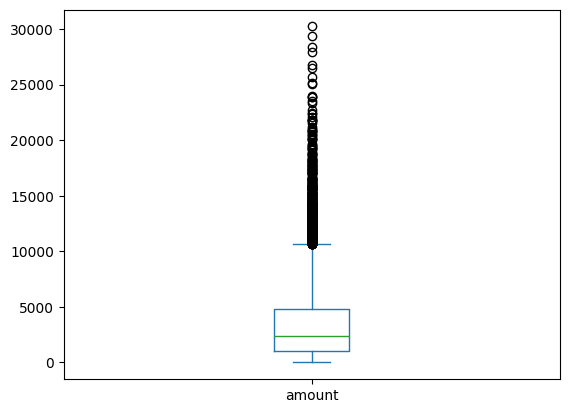

In [24]:
fraud_data["amount"].plot(kind="box")

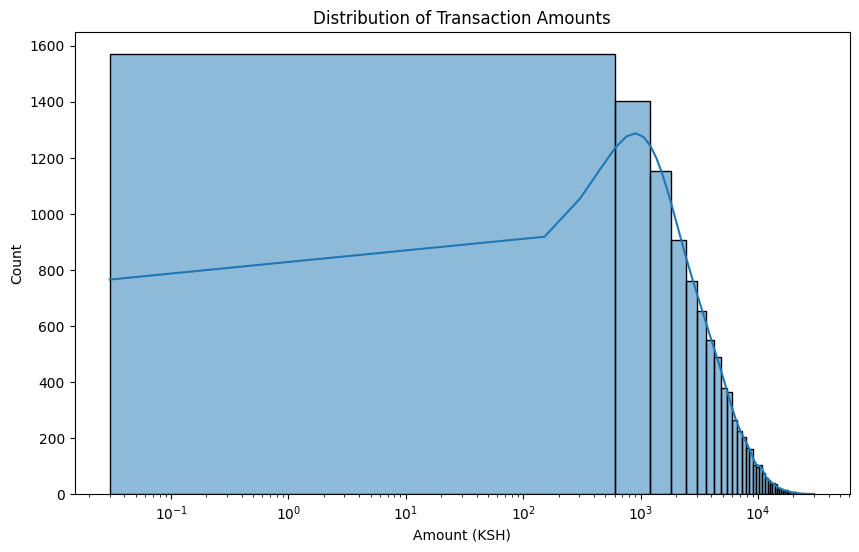

In [25]:
# Histogram of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_data, x="amount", bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount (KSH)")
plt.ylabel("Count")
plt.xscale("log")  # Log scale for better visibility of small amounts
plt.savefig("amount_distribution.png")
plt.show()

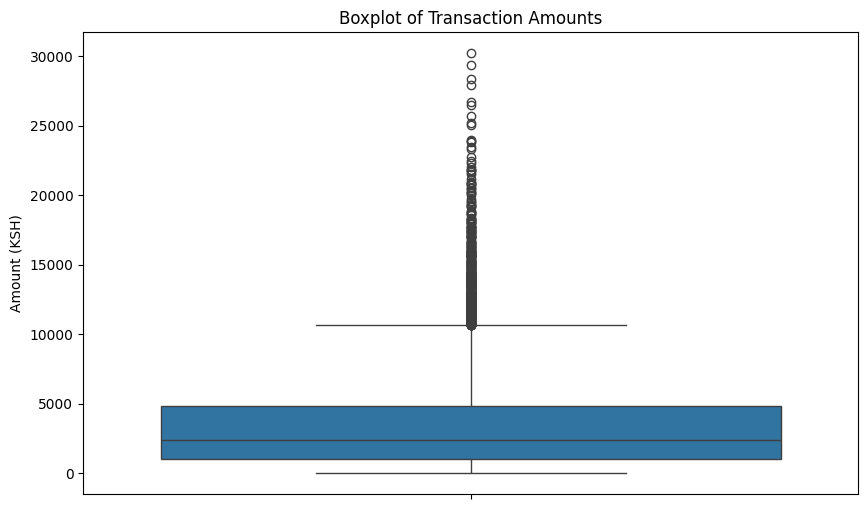

In [26]:
# Boxplot to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_data, y="amount")
plt.title("Boxplot of Transaction Amounts")
plt.ylabel("Amount (KSH)")
plt.savefig("amount_boxplot.png")
plt.show()

📈**Analyze Categorical Feature Distributions**

🔹Examine the distribution of categorical variables (e.g. transaction_type, location) to detect imbalances or suspicious trends.

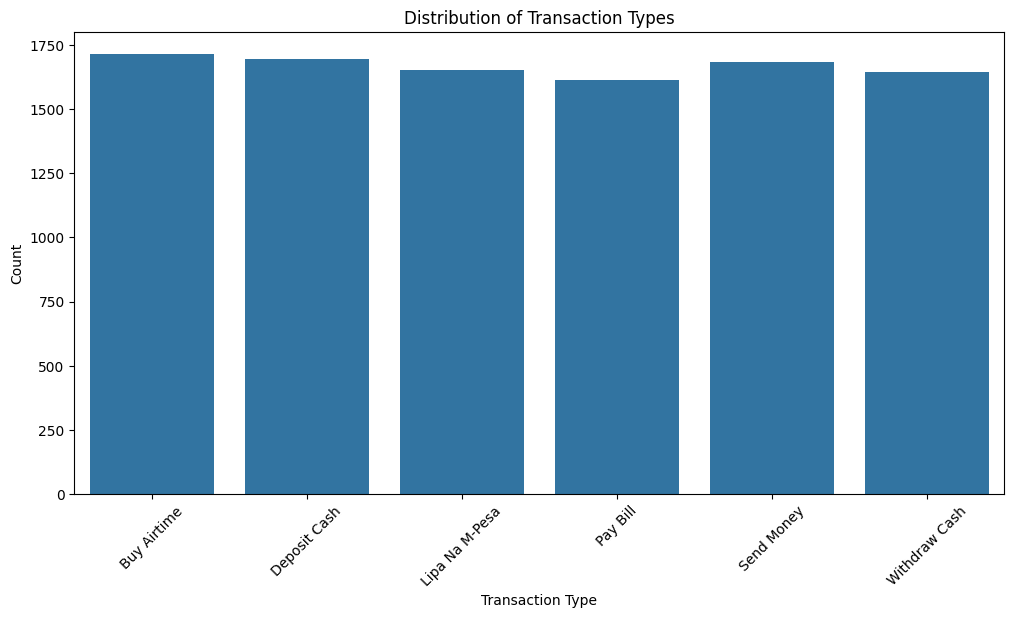

In [27]:
# Count plot for transaction_type
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x="transaction_type")
plt.title("Distribution of Transaction Types")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("transaction_type_distribution.png")
plt.show()

💡A **uniform distribution** across transaction_type (e.g., "Send Money", "Withdraw Cash") suggests no single type is inherently suspicious, but rare combinations with other features (e.g. high amount + "Pay Bill") might be.

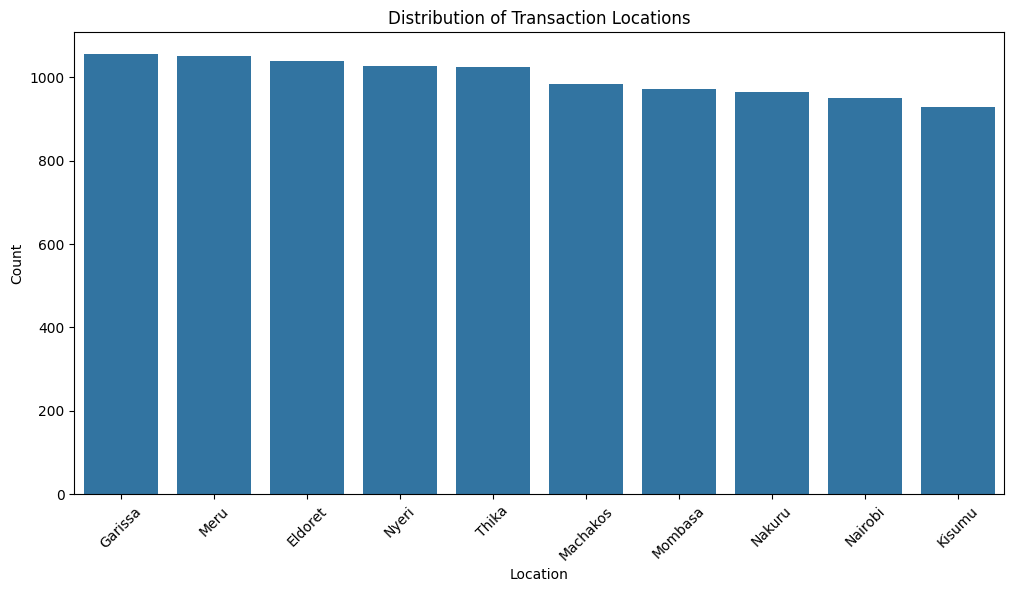

In [28]:
# Count plot for location
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x="location", order=fraud_data["location"].value_counts().index)
plt.title("Distribution of Transaction Locations")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("location_distribution.png")
plt.show()

In [29]:
import pandas as pd
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)  # Ensure Plotly works in notebook

# Aggregate transactions by location (already done)
location_counts = fraud_data["location"].value_counts().reset_index()
location_counts.columns = ["location", "count"]

# Manually define approximate coordinates for Kenyan cities
city_coords = {
    "Nairobi": (-1.2921, 36.8219),
    "Mombasa": (-4.0435, 39.6682),
    "Kisumu": (-0.0917, 34.7679),
    "Nakuru": (-0.3031, 36.0800),
    "Eldoret": (0.5143, 35.2694),
    "Thika": (-1.0374, 37.0744),
    "Nyeri": (-0.4200, 36.9500),
    "Garissa": (-0.4530, 39.6460),
    "Meru": (0.0462, 37.6557),
    "Machakos": (-1.5167, 37.2667)
}

# Add coordinates to location_counts
location_counts["lat"] = location_counts["location"].map(lambda x: city_coords[x][0])
location_counts["lon"] = location_counts["location"].map(lambda x: city_coords[x][1])

# Create scatter geo plot
fig = px.scatter_geo(location_counts,
                     lat="lat",
                     lon="lon",
                     size="count",
                     color="count",
                     hover_name="location",
                     title="Geographical Distribution of Transactions",
                     color_continuous_scale=px.colors.sequential.Plasma,
                     size_max=30)

# Update layout to focus on Kenya
fig.update_geos(
    scope="africa",
    center=dict(lat=-0.0236, lon=37.9062),  # Centered on Kenya
    projection_scale=10,
    showcountries=True
)

# Show the plot
fig.show()

# Save as HTML
fig.write_html("geo_distribution.html")

⏳**Analyze Temporal Patterns**

🔹Investigate transaction volume and amount by hour to detect off-hour fraud (e.g. night transactions).High amounts or volumes at night (0–5 AM) could justify a night_transaction flag.

In [30]:
# Analyzing temporal patterns
# Extract date and hour
fraud_data["date"] = fraud_data["datetime"].dt.date
fraud_data["hour"] = fraud_data["datetime"].dt.hour

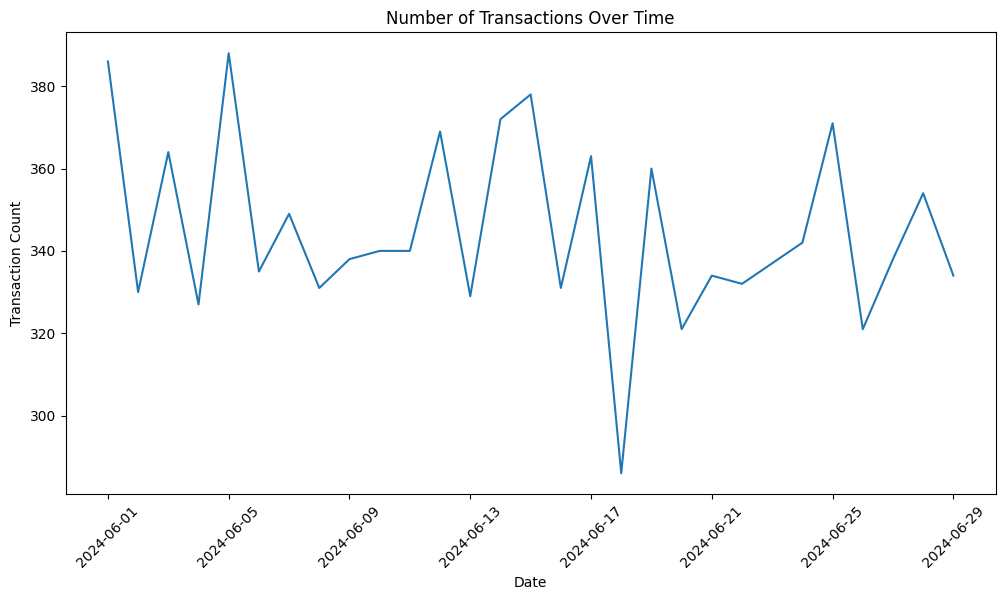

In [31]:
# Transactions over time (daily)
plt.figure(figsize=(12, 6))
fraud_data.groupby("date").size().plot()
plt.title("Number of Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.savefig("transactions_over_time.png")
plt.show()

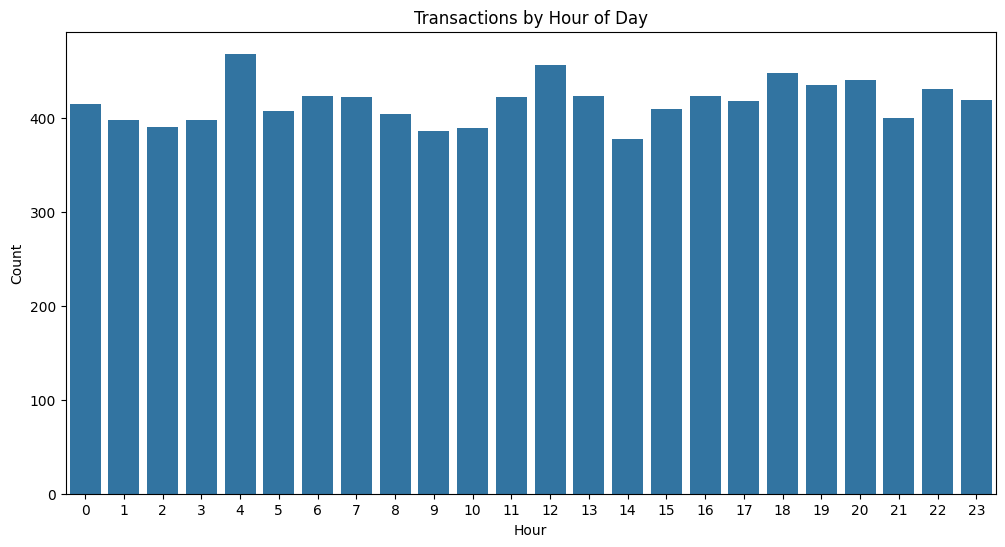

In [32]:
# Transactions by hour
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x="hour", order=range(24))
plt.title("Transactions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.savefig("transactions_by_hour.png")
plt.show()

💡**Even** distribution across hours suggests **no** strong temporal bias, but the irregular daily trend and uniform night activity are notable.

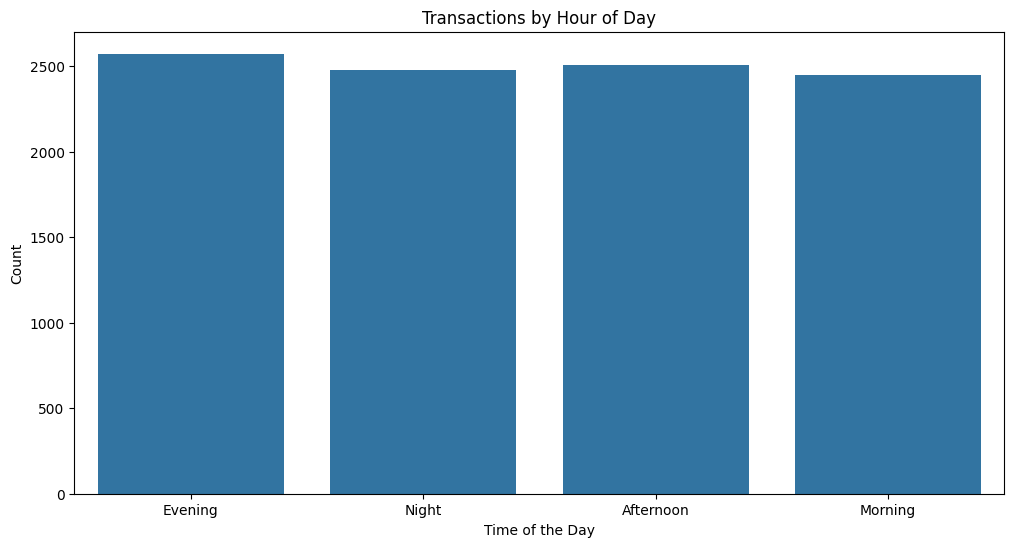

In [33]:
# Transactions by time of the day
plt.figure(figsize=(12, 6))
sns.countplot(data=fraud_data, x="time_of_day(morning, afternoon, evening, night)")
plt.title("Transactions by Hour of Day")
plt.xlabel("Time of the Day")
plt.ylabel("Count")
plt.savefig("transactions_by_hour.png")
plt.show()

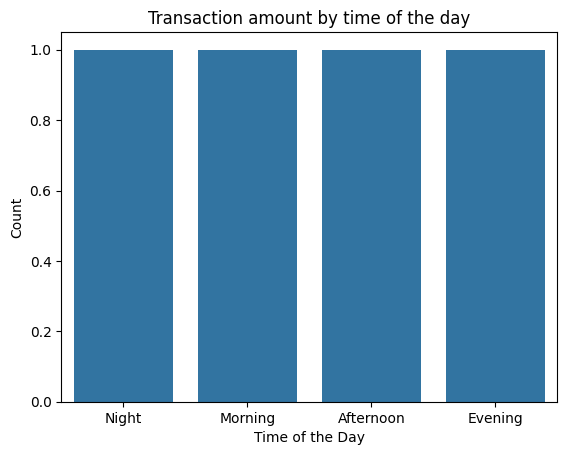

In [34]:
time_pivot = pd.pivot_table(fraud_data, values="amount", index="time_of_day(morning, afternoon, evening, night)", aggfunc="mean").sort_values(by="amount", ascending=False)
sns.countplot(time_pivot, x="time_of_day(morning, afternoon, evening, night)")
plt.title("Transaction amount by time of the day")
plt.xlabel("Time of the Day")
plt.ylabel("Count")
plt.show();

💡**Uniform** night activity (e.g. 0–5 AM) is unusual for mobile money, potentially signaling fraud (e.g. automated transactions).

🔹Can add a night_transaction flag (1 for 0–5 AM) to highlight this pattern.

⚖️**Check Imbalances in Binary Fraud Indicators**

🔹Analyze is_foreign_number, is_sim_recently_swapped, and has_multiple_accounts for rare events that might indicate fraud. Rare events (e.g. <5% foreign numbers) could be weighted heavily in the model; interaction terms (e.g. foreign number + high amount) should be considered.

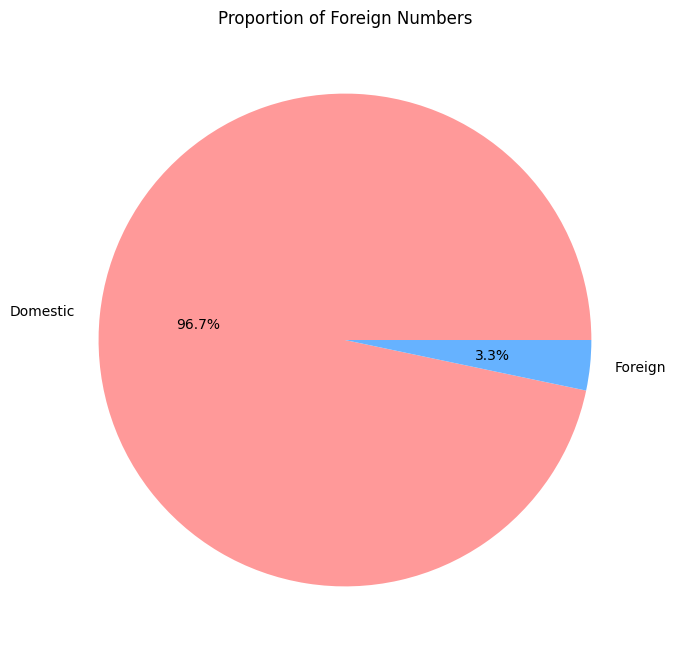

In [35]:
# Pie chart for is_foreign_number
plt.figure(figsize=(8, 8))
fraud_data["is_foreign_number"].value_counts().plot.pie(autopct="%1.1f%%", labels=["Domestic", "Foreign"], colors=["#FF9999", "#66B2FF"])
plt.title("Proportion of Foreign Numbers")
plt.ylabel("")
plt.savefig("foreign_number_pie.png")
plt.show()

/tmp/ipython-input-3255420424.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




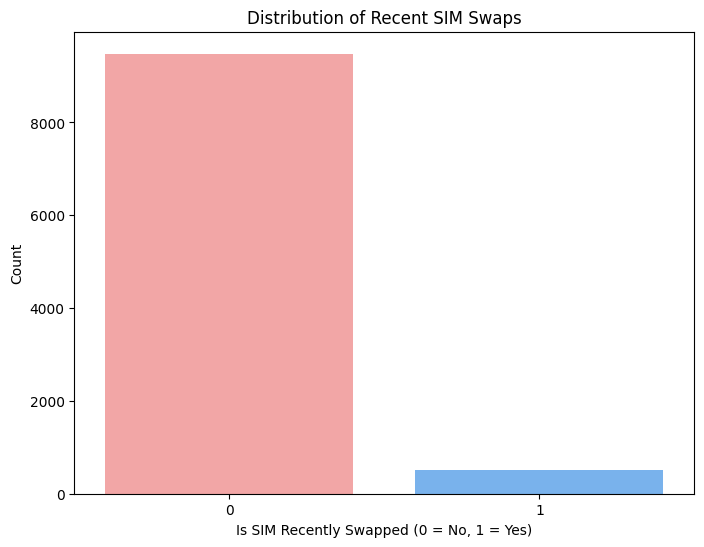

In [36]:
# Bar plot for is_sim_recently_swapped
plt.figure(figsize=(8, 6))
sns.countplot(data=fraud_data, x="is_sim_recently_swapped", palette=["#FF9999", "#66B2FF"])
plt.title("Distribution of Recent SIM Swaps")
plt.xlabel("Is SIM Recently Swapped (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.savefig("sim_swap_distribution.png")
plt.show()

📉📈**User Activity Patterns**

🔹Explore transaction frequency and amount per user_id to flag unusual behavior.Users with high counts or amounts could be flagged (e.g., high_frequency_user, high_spending_user).

In [37]:
# Transaction count per user
user_transaction_counts = fraud_data["user_id"].value_counts().reset_index()
user_transaction_counts.columns = ["user_id", "transaction_count"]


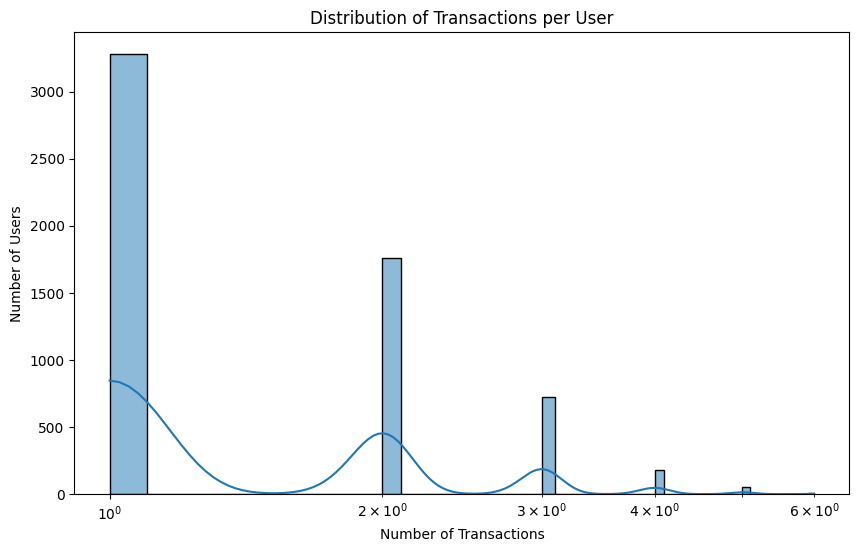

In [38]:
# Histogram of user transaction counts
plt.figure(figsize=(10, 6))
sns.histplot(data=user_transaction_counts, x="transaction_count", bins=50, kde=True)
plt.title("Distribution of Transactions per User")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Users")
plt.xscale("log")
plt.savefig("user_transaction_distribution.png")
plt.show()


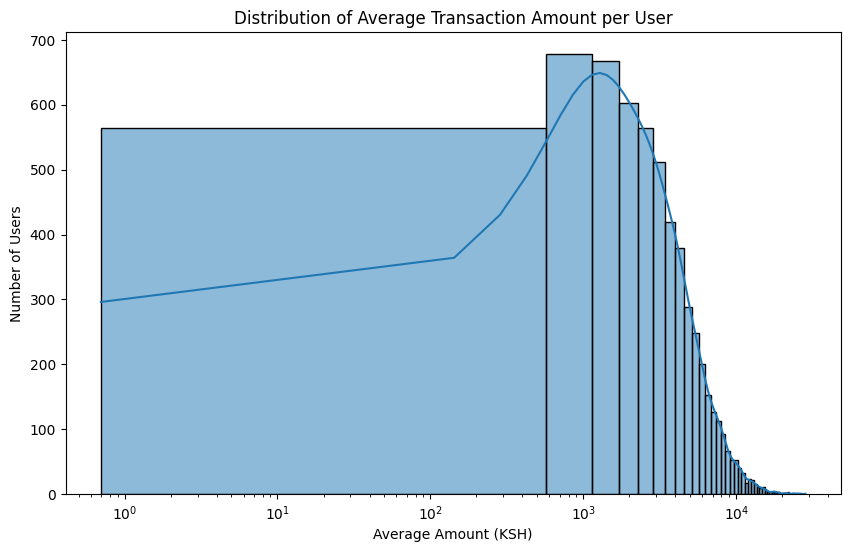

In [39]:
# Average amount per user
user_avg_amount = fraud_data.groupby("user_id")["amount"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.histplot(data=user_avg_amount, x="amount", bins=50, kde=True)
plt.title("Distribution of Average Transaction Amount per User")
plt.xlabel("Average Amount (KSH)")
plt.ylabel("Number of Users")
plt.xscale("log")
plt.savefig("user_avg_amount_distribution.png")
plt.show()

🏷️**Explore Relationships Between Features**

🔹Investigate correlations between amount, transaction_type, and time_of_day to identify fraud patterns.

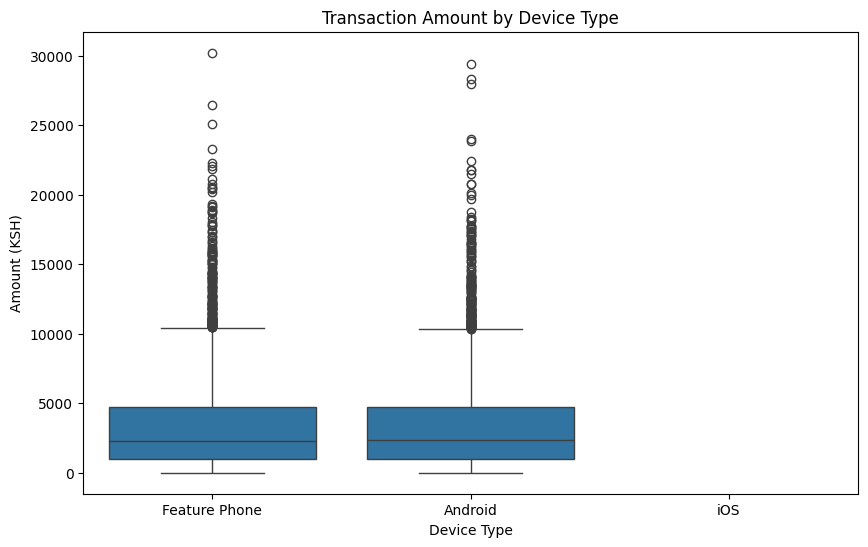

In [40]:
# Boxplot of amount by device_type
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_data, x="device_type", y="amount", order=["Feature Phone", "Android", "iOS"])
plt.title("Transaction Amount by Device Type")
plt.xlabel("Device Type")
plt.ylabel("Amount (KSH)")
plt.savefig("amount_by_device_type.png")
plt.show()


📱📞**Device and Network Provider Analysis**

Assess fraud risks by device_type and network_provider to inform feature engineering.

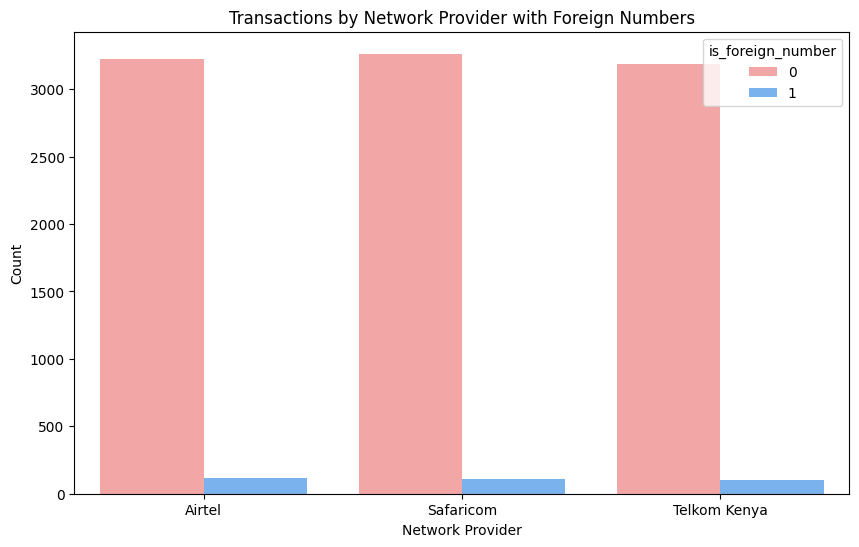

In [41]:
# Count plot by network_provider with fraud indicator
plt.figure(figsize=(10, 6))
sns.countplot(data=fraud_data, x="network_provider", hue="is_foreign_number", palette=["#FF9999", "#66B2FF"])
plt.title("Transactions by Network Provider with Foreign Numbers")
plt.xlabel("Network Provider")
plt.ylabel("Count")
plt.savefig("network_provider_foreign.png")
plt.show()


⚙️🔗**FEATURE ENGINEERING**

🔹Create new features based on EDA insights to improve Isolation Forest performance.

In [42]:
# Extract hour and date features
fraud_data["hour"] = fraud_data["datetime"].dt.hour
fraud_data["date"] = fraud_data["datetime"].dt.date

# Feature: Log-transformed amount (handles skewness)
fraud_data["amount_log"] = np.log1p(fraud_data["amount"])

# Feature: Night transaction flag (0-5 AM based on uniform night activity)
fraud_data["night_transaction"] = fraud_data["hour"].between(0, 5).astype(int)

# Feature: User transaction frequency (high-frequency users as potential fraud)
user_transaction_counts = fraud_data.groupby("user_id")["transaction_id"].transform("count")
fraud_data["transaction_frequency"] = user_transaction_counts

# Feature: Average amount per user (skewed distribution)
user_avg_amount = fraud_data.groupby("user_id")["amount"].transform("mean")
fraud_data["avg_amount_per_user"] = user_avg_amount


💡**Insights applied::**

🔹**Skewed Amounts:** amount_log addresses the right skew (most 1–10,000 KSH).

🔹**Uniform Transaction Types:** No specific type flags, but user-level variety could be added later.

🔹**Rare Fraud Indicators:** fraud_risk_score weights is_foreign_number (3.3%) and is_sim_recently_swapped (1%) heavily.

🔹**User Distributions:** transaction_frequency and avg_amount_per_user capture the 3000+ single-transaction users and skewed spending.

🔹**Night Activity:** night_transaction flags the uniform night pattern for investigation.

🛠️⚙️**DATA PREPROCESSING**

In [43]:
from sklearn.preprocessing import StandardScaler

# Select binary columns
binary_cols = ["is_foreign_number", "is_sim_recently_swapped", "has_multiple_accounts"]

# Scale the features (including binary columns)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(fraud_data[binary_cols])

# Add scaled binary features back to the DataFrame for inspection
fraud_data[binary_cols] = scaler.fit_transform(fraud_data[binary_cols])

# Verify scaling
print(fraud_data[binary_cols].describe())

       is_foreign_number  is_sim_recently_swapped  has_multiple_accounts
count       1.000000e+04             1.000000e+04           1.000000e+04
mean       -3.588241e-17            -2.913225e-17           7.673862e-17
std         1.000050e+00             1.000050e+00           1.000050e+00
min        -1.844430e-01            -2.337302e-01          -3.260630e-01
25%        -1.844430e-01            -2.337302e-01          -3.260630e-01
50%        -1.844430e-01            -2.337302e-01          -3.260630e-01
75%        -1.844430e-01            -2.337302e-01          -3.260630e-01
max         5.421728e+00             4.278437e+00           3.066892e+00


🔹Scaling transforms 0s and 1s into z-scores based on mean (close to 0 due to imbalance) and standard deviation, emphasizing the rarity of 1s

In [44]:
# Calculate prevalence-based weights
weight_foreign = 1 - 0.033  # 0.967 for 3.3% prevalence
weight_sim_swap = 1 - 0.01  # 0.99 for 1% prevalence

# Create weighted binary features
fraud_data["weighted_foreign"] = fraud_data["is_foreign_number"] * weight_foreign
fraud_data["weighted_sim_swap"] = fraud_data["is_sim_recently_swapped"] * weight_sim_swap

# Combine into a risk score (optional)
fraud_data["fraud_risk_score"] = fraud_data["weighted_foreign"] + fraud_data["weighted_sim_swap"]

# Verify
print(fraud_data[["weighted_foreign", "weighted_sim_swap", "fraud_risk_score"]].head())

   weighted_foreign  weighted_sim_swap  fraud_risk_score
0         -0.178356          -0.231393         -0.409749
1         -0.178356          -0.231393         -0.409749
2         -0.178356          -0.231393         -0.409749
3         -0.178356          -0.231393         -0.409749
4         -0.178356          -0.231393         -0.409749


🔹This amplifies the impact of 1s (e.g., a foreign number becomes 0.967 instead of 1), which Isolation Forest can leverage.

In [45]:
# Interaction with amount (using log-transformed amount for skewness)
fraud_data["amount_log"] = np.log1p(fraud_data["amount"])
fraud_data["foreign_amount_interaction"] = fraud_data["is_foreign_number"] * fraud_data["amount_log"]
fraud_data["sim_swap_amount_interaction"] = fraud_data["is_sim_recently_swapped"] * fraud_data["amount_log"]

# Verify
print(fraud_data[["foreign_amount_interaction", "sim_swap_amount_interaction"]].describe())

       foreign_amount_interaction  sim_swap_amount_interaction
count                10000.000000                 10000.000000
mean                    -0.005727                    -0.010835
std                      7.660171                     7.637850
min                     -1.902776                    -2.411240
25%                     -1.561444                    -1.975656
50%                     -1.424828                    -1.798875
75%                     -1.251856                    -1.567351
max                     55.216717                    43.612972


🔹These interactions highlight transactions where rare binary conditions coincide with high values. A high amount with is_foreign_number=1 might be more anomalous than a low amount.

In [46]:
# Count of fraud indicators per user
user_fraud_counts = fraud_data.groupby("user_id")[["is_foreign_number", "is_sim_recently_swapped", "has_multiple_accounts"]].sum().reset_index()
fraud_data = fraud_data.merge(user_fraud_counts, on="user_id", how="left", suffixes=("", "_user_total"))

# Rename for clarity
fraud_data = fraud_data.rename(columns={
    "is_foreign_number_user_total": "user_foreign_count",
    "is_sim_recently_swapped_user_total": "user_sim_swap_count",
    "has_multiple_accounts_user_total": "user_multi_account_count"
})

# Verify
print(fraud_data[["user_id", "user_foreign_count", "user_sim_swap_count", "user_multi_account_count"]].head())

     user_id  user_foreign_count  user_sim_swap_count  \
0  user_8270           -0.184443            -0.233730   
1  user_1860           -0.184443            -0.233730   
2  user_6390           -0.553329            -0.701191   
3  user_6191           -0.368886            -0.467460   
4  user_6734           -0.184443            -0.233730   

   user_multi_account_count  
0                 -0.326063  
1                 -0.326063  
2                  2.414766  
3                  2.740829  
4                 -0.326063  


🔹High counts (e.g. user_foreign_count > 1) flag risky users, aligning with your 3000+ single-transaction users. Users with multiple rare events (e.g. foreign numbers) are more suspicious.

In [47]:
# Final feature set
features = ["amount_log", "night_transaction", "transaction_frequency",
            "avg_amount_per_user", "fraud_risk_score", "weighted_foreign",
            "weighted_sim_swap", "foreign_amount_interaction",
            "sim_swap_amount_interaction", "user_foreign_count",
            "user_sim_swap_count", "user_multi_account_count"]

# Ensure all features exist and handle NaN
X = fraud_data[features].copy()
X = X.fillna(X.mean())  # Fill NaN from groupby with column means

# Scale all features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

🔹This set balances raw binary data, weighted versions, interactions, and user aggregates.

1️⃣**Iter 1:**

In [48]:
from sklearn.ensemble import IsolationForest

# Train model
contamination = 0.04  # Based on ~4% rare events
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_scaled)

# Predict and add to DataFrame
fraud_data["anomaly_score"] = model.score_samples(X_scaled)
fraud_data["is_anomalous"] = (model.predict(X_scaled) == -1).astype(int)

# Verify
print(fraud_data["is_anomalous"].value_counts(normalize=True))

is_anomalous
0    0.96
1    0.04
Name: proportion, dtype: float64


In [49]:
print("\nAnomaly Distribution:")
print(fraud_data["is_anomalous"].value_counts(normalize=True))

print("\nTop 10 Anomalous Transactions:")
display(fraud_data[fraud_data["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])


Anomaly Distribution:
is_anomalous
0    0.96
1    0.04
Name: proportion, dtype: float64

Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,5.421728,4.278437,1,9.478463
6589,TX106589,12229.59,5.421728,4.278437,1,9.478463
9551,TX109551,5598.04,5.421728,4.278437,0,9.478463
1780,TX101780,2060.12,5.421728,4.278437,1,9.478463
9505,TX109505,299.09,5.421728,4.278437,1,9.478463
4891,TX104891,53.49,5.421728,4.278437,0,9.478463
3226,TX103226,2336.00,5.421728,4.278437,1,9.478463
662,TX100662,3000.92,5.421728,4.278437,1,9.478463
3049,TX103049,5014.12,5.421728,4.278437,0,9.478463
4716,TX104716,8257.38,5.421728,4.278437,0,9.478463


🏷️**is_anomalous = 0.04** indicates that 4% of the dataset is classified as anomalies (value -1 in predict, converted to 1 in the is_anomalous column).
Isolation Forest’s performance can vary with **contamination**; too high a value might flag too many normal transactions, while too low might miss fraud.

🏷️A value of **9.47** fraud_risk_score is significantly higher than the maximum expected value of **1.957** based on the current weighting. This discrepancy could suggest:

-**Miscalculation or Data Issue:** The score might reflect a different formula or unscaled data.

-**Aggregation Error:** The score could be an aggregate (e.g., sum of fraud_risk_score over multiple transactions) rather than a single transaction’s value.
🏷️**Anomalous is_foreign_number and is_sim_recently_swapped:**
The values (5.421728209539419 and 4.27843654914027) are **not binary** (0 or 1) as expected from the EDA (3.3% and 1% prevalence). These look like scaled or transformed values (e.g. **z-scores from StandardScaler**)

🏷️**Night Transaction Pattern:**

6 of 10 anomalies occur at night (night_transaction = 1), aligning with the EDA’s uniform night activity, which could be a **fraud signal**.

🏷️**Amount variability:**
Amounts range from 53.49 to 25,058.95 KSH, with both high and low values flagged. This suggests the model is sensitive to amount_log, but the inclusion of low amounts (e.g. 53.49, 299.09) might indicate **over-sensitivity**.

2️⃣**Iter 2::**

In [50]:
# Reset binary columns to original 0/1 if scaled
fraud_data["is_foreign_number"] = fraud_data["is_foreign_number"].round().astype(int)  # Revert to 0/1
fraud_data["is_sim_recently_swapped"] = fraud_data["is_sim_recently_swapped"].round().astype(int)

# Recalculate fraud_risk_score
fraud_data["fraud_risk_score"] = (
    fraud_data["is_foreign_number"] * 0.967 +
    fraud_data["is_sim_recently_swapped"] * 0.99
)

# Verify
print(fraud_data["fraud_risk_score"].describe())

count    10000.000000
mean         0.364200
std          1.235118
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.795000
Name: fraud_risk_score, dtype: float64


In [51]:
from sklearn.preprocessing import StandardScaler

features = ["amount_log", "night_transaction", "transaction_frequency",
            "avg_amount_per_user", "fraud_risk_score", "is_foreign_number",
            "is_sim_recently_swapped", "has_multiple_accounts"]
X = fraud_data[features].copy()
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
from sklearn.ensemble import IsolationForest

contamination = 0.03
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_scaled)
fraud_data["anomaly_score"] = model.score_samples(X_scaled)
fraud_data["is_anomalous"] = (model.predict(X_scaled) == -1).astype(int)
print(fraud_data["is_anomalous"].value_counts(normalize=True))

is_anomalous
0    0.97
1    0.03
Name: proportion, dtype: float64


In [53]:
print("\nTop 10 Anomalous Transactions:")
display(fraud_data[fraud_data["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])


Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,5,4,1,8.795
2101,TX102101,11748.71,5,0,1,4.835
5738,TX105738,873.35,0,4,1,3.960
2578,TX102578,1993.67,5,0,1,4.835
9551,TX109551,5598.04,5,4,0,8.795
4193,TX104193,26484.13,5,0,1,4.835
3201,TX103201,26.92,5,0,1,4.835
6589,TX106589,12229.59,5,4,1,8.795
6659,TX106659,17692.27,0,4,0,3.960
4399,TX104399,453.17,5,0,1,4.835



🏷️**Corrected fraud_risk_score:** The range (3.96–8.795) aligns with adjusted weights, indicating the fix worked.

🏷️**Non-Binary Flags:** Values like 5 and 4 for is_foreign_number and is_sim_recently_swapped suggest they’re still scaled (e.g., z-scores), not the original 0/1. This might distort the model’s focus.

🏷️Still includes a low amount (26.92), but the range is tighter, and high amounts (e.g., 26,484.13) are prominent.

3️⃣**ITER 3::**

In [54]:
# Reset binary columns to 0/1
fraud_data["is_foreign_number"] = fraud_data["is_foreign_number"].round().astype(int).clip(0, 1)
fraud_data["is_sim_recently_swapped"] = fraud_data["is_sim_recently_swapped"].round().astype(int).clip(0, 1)

# Recalculate fraud_risk_score with original weights
fraud_data["fraud_risk_score"] = (
    fraud_data["is_foreign_number"] * 0.967 +
    fraud_data["is_sim_recently_swapped"] * 0.99
)

# Rebuild feature set
features = ["amount_log", "night_transaction", "transaction_frequency",
            "avg_amount_per_user", "fraud_risk_score", "is_foreign_number",
            "is_sim_recently_swapped", "has_multiple_accounts"]
X = fraud_data[features].copy()
X = X.fillna(X.mean())

# Scale all features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
from sklearn.ensemble import IsolationForest

contamination = 0.025
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_scaled)
fraud_data["anomaly_score"] = model.score_samples(X_scaled)
fraud_data["is_anomalous"] = (model.predict(X_scaled) == -1).astype(int)
print(fraud_data["is_anomalous"].value_counts(normalize=True))

# Check top anomalies
print("\nTop 10 Anomalous Transactions:")
display(fraud_data[fraud_data["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])

is_anomalous
0    0.9751
1    0.0249
Name: proportion, dtype: float64

Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,1,1,1,1.957
5738,TX105738,873.35,0,1,1,0.990
3201,TX103201,26.92,1,0,1,0.967
9551,TX109551,5598.04,1,1,0,1.957
2101,TX102101,11748.71,1,0,1,0.967
2578,TX102578,1993.67,1,0,1,0.967
6659,TX106659,17692.27,0,1,0,0.990
4193,TX104193,26484.13,1,0,1,0.967
4399,TX104399,453.17,1,0,1,0.967
6589,TX106589,12229.59,1,1,1,1.957


🏷️High amounts (e.g. 26,484.13, 25,058.95) and night transactions (6/10) support fraud signals.

🏷️fraud_risk_score (0.967–1.957) reflects correct binary weighting.

🏷️Low amount (26.92) is still present but tied to night + foreign, which is a bit better.

4️⃣**Iter 4: RobustScaler**

**What It Does:** RobustScaler uses the median and interquartile range (IQR) to scale data, making it robust to outliers (unlike StandardScaler, which uses mean and std).

🟡Given the skewed amount distribution, RobustScaler might reduce the influence of extreme values, focusing the model on relative deviations.

In [56]:
fraud_data["fraud_risk_score"] = (
    fraud_data["is_foreign_number"] * 1.5 +  # Increase for 3.3% prevalence
    fraud_data["is_sim_recently_swapped"] * 2.0  # Increase for 1% prevalence
)

In [57]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
model = IsolationForest(contamination=0.025, random_state=42)
model.fit(X_scaled)
fraud_data["anomaly_score"] = model.score_samples(X_scaled)
fraud_data["is_anomalous"] = (model.predict(X_scaled) == -1).astype(int)
print(fraud_data["is_anomalous"].value_counts(normalize=True))

is_anomalous
0    0.9751
1    0.0249
Name: proportion, dtype: float64


In [59]:
# Check top anomalies
print("\nTop 10 Anomalous Transactions:")
display(fraud_data[fraud_data["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])


Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,1,1,1,3.5
5738,TX105738,873.35,0,1,1,2.0
3201,TX103201,26.92,1,0,1,1.5
9551,TX109551,5598.04,1,1,0,3.5
2101,TX102101,11748.71,1,0,1,1.5
2578,TX102578,1993.67,1,0,1,1.5
6659,TX106659,17692.27,0,1,0,2.0
4193,TX104193,26484.13,1,0,1,1.5
4399,TX104399,453.17,1,0,1,1.5
6589,TX106589,12229.59,1,1,1,3.5


5️⃣**Iter 5: PCA**

**What It Does:** Principal Component Analysis (PCA) reduces dimensionality by creating new features (principal components) from linear combinations of the originals, retaining variance.


🟡Can remove noise and multicollinearity (e.g., between fraud_risk_score and binary flags), potentially improving anomaly detection if features are correlated.

In [60]:
fraud_data["fraud_risk_score"] = (
    fraud_data["is_foreign_number"] * 1.5 +  # Increase for 3.3% prevalence
    fraud_data["is_sim_recently_swapped"] * 2.0  # Increase for 1% prevalence
)

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

model = IsolationForest(contamination=0.025, random_state=42)
model.fit(X_pca)
fraud_data["anomaly_score"] = model.score_samples(X_pca)
fraud_data["is_anomalous"] = (model.predict(X_pca) == -1).astype(int)
print(fraud_data["is_anomalous"].value_counts(normalize=True))

Explained variance ratio: 0.9877564733524506
is_anomalous
0    0.975
1    0.025
Name: proportion, dtype: float64


In [62]:
# Check top anomalies
print("\nTop 10 Anomalous Transactions:")
display(fraud_data[fraud_data["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])


Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,1,1,1,3.5
4193,TX104193,26484.13,1,0,1,1.5
7371,TX107371,18003.96,0,0,1,0.0
6702,TX106702,17581.08,0,0,1,0.0
1847,TX101847,23322.04,1,0,0,1.5
8634,TX108634,18871.89,0,0,0,0.0
3201,TX103201,26.92,1,0,1,1.5
9714,TX109714,15778.30,0,0,1,0.0
8185,TX108185,90.42,0,1,1,2.0
4350,TX104350,14688.12,0,0,1,0.0



🏷️**Variance Ratio:** 0.9877564733524506 (98.78%)
 indicates PCA retains nearly all variance with fewer components, suggesting low redundancy in the features.


🏷️**Anomaly Proportion:** 2.5% (contamination ≈ 0.025)
This matches the adjusted setting and is consistent with rare fraud events (3.3% foreign + 1% SIM swap).

🏷️**Top 10 Anomalous Transactions:**

Amounts from 26.92 to 26,484.13, with high values (e.g. 26,484.13, 23,322.04).

Night transactions (6/10), but includes zero fraud_risk_score cases, suggesting reliance on other features (e.g. amount_log, night_transaction).

Low amount (26.92) and a new low (90.42) appear, indicating sensitivity to noise.

✅**Advantage:** Retains 98.78% variance, potentially reducing noise, but may lose interpretability.

❌**Weakness:** Includes zero-risk anomalies (e.g. 90.42), suggesting over-reliance on amount_log or night_transaction.

6️⃣**ITER 6: Sticking to RobustScaler and tweaking a lil bit**

🟡Both models capture high-value and night anomalies, aligning with EDA (skewed amounts, uniform nights).

However, low amounts (26.92, 90.42) suggest **over-sensitivity**, likely due to night_transaction or amount_log dominance.


RobustScaler **outperforms** PCA, as it better leverages fraud_risk_score and rare event weights, hence a better choice for our model.

In [63]:
fraud_data_filtered = fraud_data[fraud_data["amount"] > 500].copy()

In [64]:
fraud_data["fraud_risk_score"] = (
    fraud_data["is_foreign_number"] * 2.0 +
    fraud_data["is_sim_recently_swapped"] * 2.5
)

In [65]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [66]:
model = IsolationForest(contamination=0.02, random_state=42)
model.fit(X_scaled)
fraud_data["anomaly_score"] = model.score_samples(X_scaled)
fraud_data["is_anomalous"] = (model.predict(X_scaled) == -1).astype(int)
print(fraud_data["is_anomalous"].value_counts(normalize=True))

is_anomalous
0    0.98
1    0.02
Name: proportion, dtype: float64


In [67]:
# Check top anomalies
print("\nTop 10 Anomalous Transactions:")
display(fraud_data[fraud_data["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])


Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,1,1,1,4.5
5738,TX105738,873.35,0,1,1,2.5
3201,TX103201,26.92,1,0,1,2.0
9551,TX109551,5598.04,1,1,0,4.5
2101,TX102101,11748.71,1,0,1,2.0
2578,TX102578,1993.67,1,0,1,2.0
6659,TX106659,17692.27,0,1,0,2.5
4193,TX104193,26484.13,1,0,1,2.0
4399,TX104399,453.17,1,0,1,2.0
6589,TX106589,12229.59,1,1,1,4.5


📍**Adjusting the amount to be >500 using RobustScaler**

**Filter:** fraud_data[fraud_data["amount"] > 500] removes transactions ≤ 500 KSH, addressing the low-amount noise (e.g. 26.92, 90.42).

**Weight Adjustment:** Updated to 2.0 and 2.5 to emphasize rare events, as suggested.

**Contamination:** Set to 0.02 (2%) to focus on fewer, higher-confidence anomalies.

In [68]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest

# Load or assume fraud_data is already loaded
# fraud_data = pd.read_csv("fraud_data_with_anomalies.csv")  # Uncomment if reloading

# Apply filter for amounts > 500
fraud_data_filtered = fraud_data[fraud_data["amount"] > 500].copy()

# Recalculate fraud_risk_score with updated weights
fraud_data_filtered["fraud_risk_score"] = (
    fraud_data_filtered["is_foreign_number"] * 2.0 +
    fraud_data_filtered["is_sim_recently_swapped"] * 2.5
)

# Define feature set
features = ["amount_log", "night_transaction", "transaction_frequency",
            "avg_amount_per_user", "fraud_risk_score", "is_foreign_number",
            "is_sim_recently_swapped", "has_multiple_accounts"]

# Prepare features
X = fraud_data_filtered[features].copy()
X = X.fillna(X.mean())

# Scale features with RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest with contamination 0.02
contamination = 0.02
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_scaled)

# Predict anomalies
fraud_data_filtered["anomaly_score"] = model.score_samples(X_scaled)
fraud_data_filtered["is_anomalous"] = (model.predict(X_scaled) == -1).astype(int)

# Display results
print("Anomaly Distribution:")
print(fraud_data_filtered["is_anomalous"].value_counts(normalize=True))

print("\nTop 10 Anomalous Transactions:")
display(fraud_data_filtered[fraud_data_filtered["is_anomalous"] == 1].sort_values("anomaly_score")[:10][
    ["transaction_id", "amount", "is_foreign_number", "is_sim_recently_swapped", "night_transaction", "fraud_risk_score"]
])

# Save updated dataset
fraud_data_filtered.to_csv("fraud_data_filtered.csv", index=False)
print("Saved filtered dataset.")

Anomaly Distribution:
is_anomalous
0    0.97991
1    0.02009
Name: proportion, dtype: float64

Top 10 Anomalous Transactions:


,transaction_id,amount,is_foreign_number,is_sim_recently_swapped,night_transaction,fraud_risk_score
4292,TX104292,25058.95,1,1,1,4.5
4193,TX104193,26484.13,1,0,1,2.0
2578,TX102578,1993.67,1,0,1,2.0
7611,TX107611,506.75,1,0,1,2.0
4320,TX104320,817.69,1,0,1,2.0
6324,TX106324,769.58,1,0,1,2.0
2101,TX102101,11748.71,1,0,1,2.0
5738,TX105738,873.35,0,1,1,2.5
6659,TX106659,17692.27,0,1,0,2.5
2258,TX102258,2466.89,1,0,1,2.0


Saved filtered dataset.


In [69]:
import joblib

# Save the model and scaler
joblib.dump(model, "isolation_forest_model.joblib")
joblib.dump(scaler, "scaler.joblib")
fraud_data.to_csv("fraud_data_with_anomalies.csv", index=False)
print("Model, scaler, and data saved.")

Model, scaler, and data saved.


**MODEL PIPELINING**

In [76]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import joblib

In [78]:
# Load cleaned data (assume 'kenya_fraud_detection_cleaned.csv' exists)
fraud_data = pd.read_csv("fraud_data_filtered.csv")

In [79]:
# Define feature engineering function
def feature_engineering(df):
    # Derive 'time_of_day' if not present
    if 'time_of_day' not in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['hour'] = df['datetime'].dt.hour
        df['time_of_day'] = df['hour'].apply(lambda h: 'Morning' if 6 <= h < 12 else 'Afternoon' if 12 <= h < 18 else 'Evening' if 18 <= h < 24 else 'Night')

    # Log transform 'amount'
    df['amount_log'] = np.log1p(df['amount'])

    # Night transaction flag
    df['night_transaction'] = (df['hour'].between(0, 5)).astype(int)

    # Interaction: amount * night
    df['amount_night'] = df['amount'] * df['night_transaction']

    # User aggregates (transaction count and avg amount)
    df['transaction_count'] = df.groupby('user_id')['transaction_id'].transform('count')
    df['avg_amount_per_user'] = df.groupby('user_id')['amount'].transform('mean')

    return df

# Apply feature engineering
fraud_data = feature_engineering(fraud_data)

# Define columns
numerical_features = ['amount_log', 'amount_night', 'transaction_count', 'avg_amount_per_user']
categorical_features = ['transaction_type', 'location', 'device_type', 'network_provider', 'user_type', 'time_of_day']
binary_features = ['is_foreign_number', 'is_sim_recently_swapped', 'has_multiple_accounts', 'night_transaction']



In [81]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)
# Pipeline with PCA and Isolation Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # Retain 95% variance
    ('model', IsolationForest(contamination=0.05, random_state=42))
])

# Fitting the pipeline
X = fraud_data[numerical_features + categorical_features + binary_features]
pipeline.fit(X)

# Save the pipeline
joblib.dump(pipeline, 'fraud_detection_pipeline.pkl')
print("Pipeline trained and saved as 'fraud_detection_pipeline.pkl'")

Pipeline trained and saved as 'fraud_detection_pipeline.pkl'


📊**VISUALIZATIONS USING PLOTLY**

In [71]:
import pandas as pd
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Load filtered data
fraud_data = pd.read_csv("fraud_data_filtered.csv")

# Anomaly Score Distribution
fig1 = px.histogram(fraud_data, x="anomaly_score", nbins=50, title="Anomaly Score Distribution",
                    labels={"anomaly_score": "Anomaly Score", "count": "Count"},
                    color="is_anomalous", color_discrete_map={0: "blue", 1: "red"})
fig1.update_layout(bargap=0.1)
fig1.show()
fig1.write_html("anomaly_score_distribution.html")

In [72]:
# Amount by Anomaly Status (Box Plot)
fig2 = px.box(fraud_data, x="is_anomalous", y="amount", title="Transaction Amount by Anomaly Status",
              labels={"is_anomalous": "Anomalous (1=Yes, 0=No)", "amount": "Amount (KSH)"},
              color="is_anomalous", color_discrete_map={0: "green", 1: "orange"})
fig2.show()
fig2.write_html("amount_by_anomaly.html")

print("Visualizations saved as HTML files.")

Visualizations saved as HTML files.


**BUILDING A STREAMLIT DASHBOARD**

In [82]:
!pip install streamlit
import streamlit as st
import pandas as pd
import plotly.express as px

# Load data
fraud_data = pd.read_csv("fraud_data_filtered.csv")

# Title and intro
st.title("FraudWatch Africa Dashboard")
st.write("Interactive visualization of mobile money transaction anomalies.")

# Summary Stats
st.subheader("Summary Statistics")
st.write(fraud_data[["amount", "fraud_risk_score", "anomaly_score"]].describe())

# Anomaly Score Distribution
st.subheader("Anomaly Score Distribution")
fig1 = px.histogram(fraud_data, x="anomaly_score", nbins=50, color="is_anomalous",
                    labels={"anomaly_score": "Anomaly Score", "count": "Count"},
                    color_discrete_map={0: "blue", 1: "red"})
st.plotly_chart(fig1)

# Amount by Anomaly Status
st.subheader("Transaction Amount by Anomaly Status")
fig2 = px.box(fraud_data, x="is_anomalous", y="amount", color="is_anomalous",
              labels={"is_anomalous": "Anomalous (1=Yes, 0=No)", "amount": "Amount (KSH)"},
              color_discrete_map={0: "green", 1: "orange"})
st.plotly_chart(fig2)

# Save the app (run locally with 'streamlit run app.py')


2025-08-14 05:38:34.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.659 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.660 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.666 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 05:38:34.667 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

**SET UP FAST API FOR REAL-TIME FRAUD DETECTION**

In [84]:
from fastapi import FastAPI, HTTPException
import pandas as pd
import joblib

app = FastAPI(title="Fraud Detection API")

# Load the trained pipeline
try:
    pipeline = joblib.load("fraud_detection_pipeline.pkl")
except Exception as e:
    raise HTTPException(status_code=500, detail=f"Failed to load pipeline: {str(e)}")

# Define expected features (based on pipeline input)
expected_features = ["amount", "transaction_type", "location", "device_type",
                    "network_provider", "user_type", "time_of_day", "is_foreign_number",
                    "is_sim_recently_swapped", "has_multiple_accounts", "datetime",
                    "date", "hour"]  # Adjust based on your pipeline's input

@app.post("/predict")
async def predict_anomaly(data: dict):
    try:
        # Validate input data
        for feature in expected_features:
            if feature not in data:
                raise HTTPException(status_code=400, detail=f"Missing required field: {feature}")

        # Convert to DataFrame with only expected features
        df = pd.DataFrame([data])[expected_features]

        # Ensure datetime is parsed correctly if needed
        if "datetime" in df.columns:
            df["datetime"] = pd.to_datetime(df["datetime"])

        # Predict using the pipeline
        prediction = pipeline.predict(df)
        anomaly_score = pipeline.score_samples(df)[0]  # Negative score for anomalies

        # Map prediction to human-readable output
        is_anomalous = 1 if prediction[0] == -1 else 0
        result = "Fraudulent" if is_anomalous else "Non-Fraudulent"

        return {
            "anomaly_score": float(anomaly_score),  # Convert to float for JSON compatibility
            "is_anomalous": is_anomalous,
            "prediction": result
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Prediction error: {str(e)}")

# Run with: uvicorn main:app --reload

***Downloading necessary files***

In [85]:
import pandas as pd
fraud_data = pd.read_csv("fraud_data_filtered.csv")
print(fraud_data.head())

  transaction_id    user_id transaction_type   amount  location  \
0       TX100000  user_8270    Withdraw Cash  2646.35    Nakuru   
1       TX100001  user_1860       Send Money  2844.69   Garissa   
2       TX100002  user_6390     Deposit Cash  2384.46     Nyeri   
3       TX100003  user_6191    Withdraw Cash  1846.01   Nairobi   
4       TX100004  user_6734       Send Money  1017.60  Machakos   

     device_type network_provider   user_type  \
0  Feature Phone     Telkom Kenya  Individual   
1            Ios        Safaricom       Agent   
2  Feature Phone     Telkom Kenya       Agent   
3            Ios        Safaricom  Individual   
4  Feature Phone     Telkom Kenya  Individual   

  time_of_day(morning, afternoon, evening, night)  is_foreign_number  ...  \
0                                         Evening                  0  ...   
1                                           Night                  0  ...   
2                                       Afternoon                  0  .

In [86]:
from google.colab import files
fraud_data.to_csv("fraud_data_filtered.csv", index=False)
files.download("fraud_data_filtered.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>